In [8]:
import cv2
import numpy as np
from typing import Any, List, Optional, Tuple, Union
import matplotlib.pyplot as plt

In [2]:
def get_points(image):
    # Define the four corners of the object in the image
    points = []
    def click_event(event, x, y, flags, params):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            if len(points) == 4:
                cv2.destroyWindow('image')
            else:
                cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
                cv2.imshow('image', image)
    cv2.imshow('image', image)
    cv2.setMouseCallback('image', click_event)
    cv2.waitKey(0)
    
    return np.array(points)

In [4]:
def order_points(points) -> np.ndarray:
    """
    Order the points in a consistent manner (top-left, top-right, bottom-right, bottom-left).

    Returns:
        np.ndarray: The ordered points.
    """
    # Initialize an array with the same shape as the input points
    ordered_points = np.zeros((4, 2), dtype="float32")

    # Calculate the sum of the point coordinates (x, y)
    coord_sum = points.sum(axis=1)

    # Assign the top-left point (smallest sum) and bottom-right point (largest sum)
    ordered_points[0] = points[np.argmin(coord_sum)]
    ordered_points[2] = points[np.argmax(coord_sum)]

    # Calculate the difference between the point coordinates (x, y)
    coord_diff = np.diff(points, axis=1)

    # Assign the top-right point (smallest difference) and bottom-left point (largest difference)
    ordered_points[1] = points[np.argmin(coord_diff)]
    ordered_points[3] = points[np.argmax(coord_diff)]

    return ordered_points

In [5]:
def calculate_transform_dimensions(ordered_points: np.ndarray) -> Tuple[int, int]:
        """
        Calculate the dimensions of the transformed image after applying a perspective transformation.

        Args:
            ordered_points (np.ndarray): The ordered corner points of the chessboard (top-left, top-right, bottom-right, bottom-left).

        Returns:
            Tuple[int, int]: The width and height of the transformed image.
        """
        # Unpack the ordered points
        (top_left, top_right, bottom_right, bottom_left) = ordered_points

        # Calculate the width of the transformed image
        # Measure the distance between bottom-right and bottom-left points
        widthA = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
        # Measure the distance between top-right and top-left points
        widthB = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
        # The width of the transformed image is the maximum of the two distances
        maxWidth = max(int(widthA), int(widthB))

        # Calculate the height of the transformed image
        # Measure the distance between top-right and bottom-right points
        heightA = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
        # Measure the distance between top-left and bottom-left points
        heightB = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))
        # The height of the transformed image is the maximum of the two distances
        maxHeight = max(int(heightA), int(heightB))

        return maxWidth, maxHeight

In [6]:
def four_point_transform(image: np.ndarray, points) -> np.ndarray:
    """
    Apply a perspective transformation to obtain a top-down view of the chessboard.

    Args:
        image (np.ndarray): The input image.

    Returns:
        np.ndarray: The transformed image.
    """
    # Order the points (top-left, top-right, bottom-right, bottom-left)
    ordered_points = order_points(points)
    
    # Calculate the width and height of the new image
    maxWidth, maxHeight = calculate_transform_dimensions(ordered_points)

    # Create the destination points for the perspective transformation
    destination_points = np.array(
        [[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]],
        dtype="float32"
    )

    # Calculate the transformation matrix
    transformation_matrix = cv2.getPerspectiveTransform(ordered_points, destination_points)

    # Apply the perspective transformation
    transformed_image = cv2.warpPerspective(image, transformation_matrix, (maxWidth, maxHeight))

    return transformed_image

(-0.5, 762.5, 772.5, -0.5)

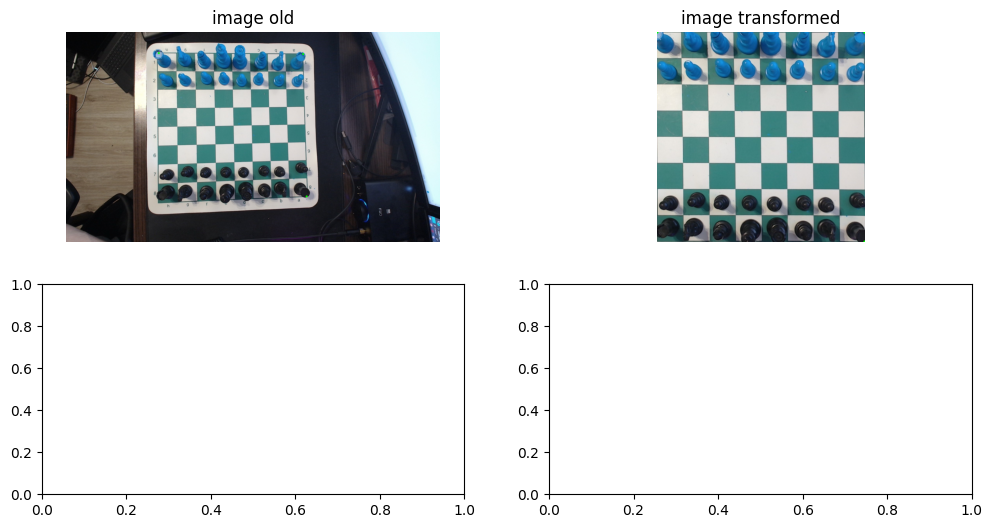

In [12]:
image = cv2.imread("./pictures/0.jpg")
points = get_points(image)
transformed_image = four_point_transform(image, points)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0,0].set_title(f"image old")
axes[0,0].axis("off")

axes[0,1].imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
axes[0,1].set_title(f"image transformed")
axes[0,1].axis("off")

In [13]:
def filter_player_pieces(top_down_image: np.ndarray) -> np.ndarray:
        """
        Filters out player pieces from the given image.

        Args:
            top_down_image (np.ndarray): The input image.

        Returns:
            np.ndarray: The filtered image containing only player pieces.
        """
        if  True:
            # Filter out the white pieces
            hsv = cv2.cvtColor(top_down_image, cv2.COLOR_BGR2HSV)
            lower_hsv = (99,175,120)
            upper_hsv = (179,255,255)
            white_pieces_mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
            filtered_image = cv2.bitwise_and(top_down_image, top_down_image, mask=white_pieces_mask)
            filtered_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
        else:
            # Filter out the black pieces
            gray_image = cv2.cvtColor(top_down_image, cv2.COLOR_BGR2GRAY)
            black_pieces_mask = cv2.inRange(top_down_image, self.lower_hsv, self.upper_hsv)
            filtered_image = cv2.bitwise_and(gray_image, gray_image, mask=black_pieces_mask)

        return filtered_image

In [14]:
def preprocess_image(image: np.ndarray) -> np.ndarray:
        """
        Preprocess the given image by filtering player pieces and applying Gaussian blur.

        Args:
            image (np.ndarray): The input image.

        Returns:
            np.ndarray: The preprocessed image.
        """
        filtered_image = filter_player_pieces(image)
        blurred_image = cv2.GaussianBlur(filtered_image, (21, 21), 0)
        return blurred_image

(-0.5, 762.5, 772.5, -0.5)

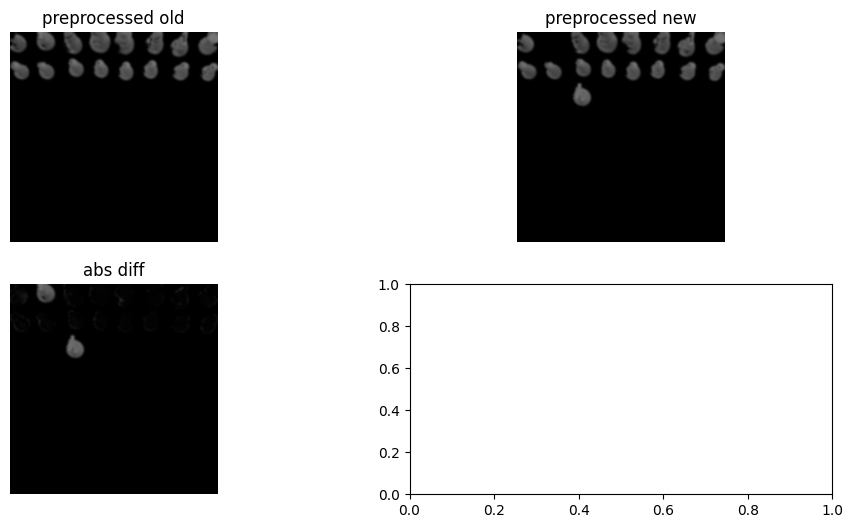

In [19]:
image1 = cv2.imread("./pictures/0.jpg")
image2 = cv2.imread("./pictures/2.jpg")
transformed_image1 = four_point_transform(image1, points)
transformed_image2 = four_point_transform(image2, points)

preprocessed_old = preprocess_image(transformed_image1)
preprocessed_new = preprocess_image(transformed_image2)
diff = cv2.absdiff(preprocessed_old, preprocessed_new)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0,0].imshow(cv2.cvtColor(preprocessed_old, cv2.COLOR_BGR2RGB))
axes[0,0].set_title(f"preprocessed old")
axes[0,0].axis("off")

axes[0,1].imshow(cv2.cvtColor(preprocessed_new, cv2.COLOR_BGR2RGB))
axes[0,1].set_title(f"preprocessed new")
axes[0,1].axis("off")

axes[1,0].imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
axes[1,0].set_title(f"abs diff")
axes[1,0].axis("off")

In [17]:
def compute_difference(image_old: np.ndarray, image_new: np.ndarray) -> np.ndarray:
    """
    Compute the difference between two preprocessed images and apply thresholding, dilation, and erosion.

    Args:
        image_old (np.ndarray): The first preprocessed image.
        image_new (np.ndarray): The second preprocessed image.

    Returns:
        np.ndarray: The thresholded difference image.
    """
    diff = cv2.absdiff(image_old, image_new)
    thresh = cv2.threshold(diff, 15, 255, cv2.THRESH_BINARY)[1]
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.dilate(thresh, kernel, iterations=2)
    thresh = cv2.erode(thresh, kernel, iterations=2)
    return thresh

(-0.5, 762.5, 772.5, -0.5)

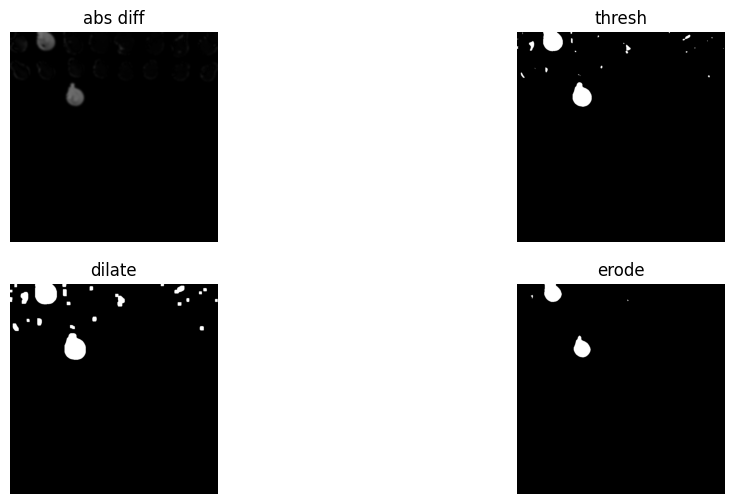

In [20]:
diff = cv2.absdiff(preprocessed_old, preprocessed_new)
thresh = cv2.threshold(diff, 15, 255, cv2.THRESH_BINARY)[1]
kernel = np.ones((5, 5), np.uint8)
dilate = cv2.dilate(thresh, kernel, iterations=2)
erode = cv2.erode(thresh, kernel, iterations=2)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0,0].imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
axes[0,0].set_title(f"abs diff")
axes[0,0].axis("off")

axes[0,1].imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
axes[0,1].set_title(f"thresh")
axes[0,1].axis("off")

axes[1,0].imshow(cv2.cvtColor(dilate, cv2.COLOR_BGR2RGB))
axes[1,0].set_title(f"dilate")
axes[1,0].axis("off")

axes[1,1].imshow(cv2.cvtColor(erode, cv2.COLOR_BGR2RGB))
axes[1,1].set_title(f"erode")
axes[1,1].axis("off")

In [31]:
def get_contours(thresh: np.ndarray, original: np.ndarray) -> np.ndarray:
    """
    Extract contours from the given thresholded difference image and draw them on the original image.

    Args:
        thresh (np.ndarray): The thresholded difference image.
        original (np.ndarray): The original image.

    Returns:
        np.ndarray: The original image with the contours drawn.
    """
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours on the original image. 
    # The third parameter is the index of contours (-1 for drawing all contours). 
    # We'll draw them in green with thickness 2
    cv2.drawContours(original, contours, -1, (255, 255, 0), 2)
    
    return original

(-0.5, 762.5, 772.5, -0.5)

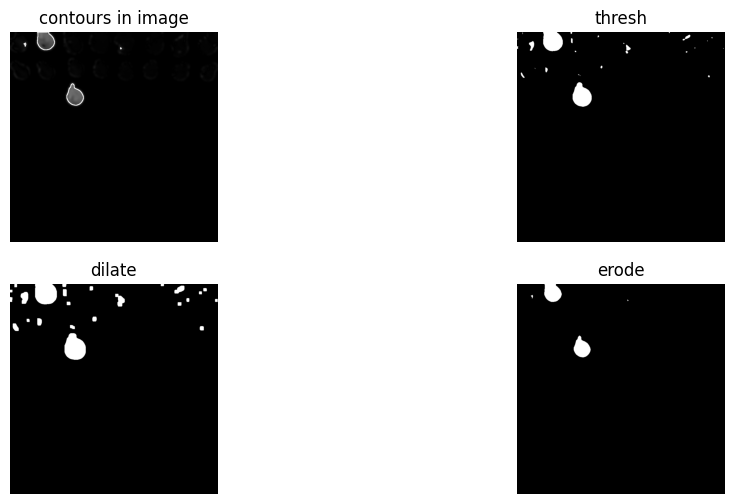

In [32]:
contour_image = get_contours(erode, diff)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0,0].imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
axes[0,0].set_title(f"contours in image")
axes[0,0].axis("off")

axes[0,1].imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
axes[0,1].set_title(f"thresh")
axes[0,1].axis("off")

axes[1,0].imshow(cv2.cvtColor(dilate, cv2.COLOR_BGR2RGB))
axes[1,0].set_title(f"dilate")
axes[1,0].axis("off")

axes[1,1].imshow(cv2.cvtColor(erode, cv2.COLOR_BGR2RGB))
axes[1,1].set_title(f"erode")
axes[1,1].axis("off")

In [47]:
def get_contours(thresh: np.ndarray) -> List[np.ndarray]:
    """
    Extract contours from the given thresholded difference image.

    Args:
        thresh (np.ndarray): The thresholded difference image.

    Returns:
        List[np.ndarray]: A list of contours.
    """
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def calculate_exponential_decay(iterator: int) -> float:
    """
    Calculate the exponential decay function value for the given iterator.

    Args:
        iterator (int): The iterator value.

    Returns:
        float: The calculated decay value.
    """
    a = 1000
    b = 0.01
    return a * np.exp(-b * iterator)

def get_move(image_old: np.ndarray, image_new: np.ndarray) -> List[str]:
    """
    Identifies the move made by the player between two images.

    Args:
        image_old (np.ndarray): The initial image.
        image_new (np.ndarray): The new image after the move.

    Returns:
        List[str]: The identified move.
    """
    preprocessed_old = preprocess_image(image_old)
    preprocessed_new = preprocess_image(image_new)

    thresh = compute_difference(preprocessed_old, preprocessed_new)
    contours = get_contours(thresh)

    square_width = preprocessed_old.shape[1] / 8
    square_height = preprocessed_old.shape[0] / 8

    move = []
    iterator = 0

    while len(move) < 2 and iterator < 500:
        for contour in contours:
            contour_area = cv2.contourArea(contour)

            if contour_area < calculate_exponential_decay(iterator):
                continue

            (x, y, w, h) = cv2.boundingRect(contour)
            cv2.rectangle(preprocessed_new, (x, y), (x + w, y + h), (255, 0, 0), 2)
            

            x_center = x + 0.5 * w
            y_center = y + 0.5 * h
            cv2.circle(preprocessed_new, (int(x_center), int(y_center)), 5 , (255, 255, 0), -1)
            x_value = int(x_center / square_width)
            y_value = int(y_center / square_height)

            square = chr(104 - x_value) + str(1 + y_value)
            move.append(square)
            move = list(set(move))
        iterator += 1
    return preprocessed_new

(-0.5, 762.5, 772.5, -0.5)

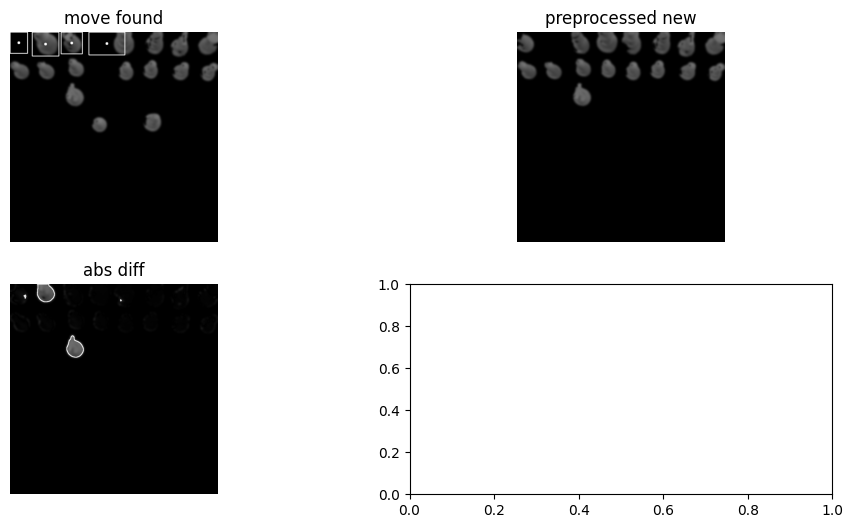

In [48]:
image1 = cv2.imread("./pictures/6.jpg")
image2 = cv2.imread("./pictures/8.jpg")
transformed_image1 = four_point_transform(image1, points)
transformed_image2 = four_point_transform(image2, points)

move_image = get_move(transformed_image1, transformed_image2)
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0,0].imshow(cv2.cvtColor(move_image, cv2.COLOR_BGR2RGB))
axes[0,0].set_title(f"move found")
axes[0,0].axis("off")

axes[0,1].imshow(cv2.cvtColor(preprocessed_new, cv2.COLOR_BGR2RGB))
axes[0,1].set_title(f"preprocessed new")
axes[0,1].axis("off")

axes[1,0].imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
axes[1,0].set_title(f"abs diff")
axes[1,0].axis("off")


In [ ]:

class ChessCam:
    def __init__(self, playerColor: int):
        self.playerColor = playerColor
        # Create a VideoCapture object
        self.cap = cv2.VideoCapture(0)
        # Check if the camera is opened successfully
        if not self.cap.isOpened():
            raise Exception("Error opening video stream or file")
        # Set the resolution to 1920x1080
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
        self.points = self.get_points()
        self.lower_hsv, self.upper_hsv = self.setup_hsv()


    @staticmethod
    def empty(_: Any) -> None:
        """
        Empty function to use as a placeholder for the trackbar callback.

        Args:
            _ (Any): Placeholder argument, not used.
        """
        pass


    def filter_image(self, image: np.ndarray, lower_hsv: np.ndarray, upper_hsv: np.ndarray) -> np.ndarray:
        """
        Filter the image based on the player's color and the given HSV values.

        Args:
            image (np.ndarray): The input image.
            lower_hsv (np.ndarray): The lower HSV values for the color range.
            upper_hsv (np.ndarray): The upper HSV values for the color range.

        Returns:
            np.ndarray: The filtered image.
        """
        # If the player's color is white (0b0)
        if self.playerColor == 0b0:
            hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            white_mask = cv2.inRange(hsv_image, lower_hsv, upper_hsv)
            filtered_image = cv2.bitwise_and(image, image, mask=white_mask)
        # If the player's color is black
        else:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            black_mask = cv2.inRange(image, lower_hsv, upper_hsv)
            filtered_image = cv2.bitwise_and(gray_image, gray_image, mask=black_mask)
        
        return filtered_image


    def apply_button(self, event: int, x: int, y: int, flags: int, param: List[bool]) -> None:
        """
        Mouse click event handler for the apply button.

        Args:
            event (int): The type of event.
            x (int): The x-coordinate of the clicked point.
            y (int): The y-coordinate of the clicked point.
            flags (int): Additional flags for the event.
            param (List[bool]): A list containing a single boolean that indicates if the button was pressed.
        """
        if event == cv2.EVENT_LBUTTONUP:
            param[0] = True


    def setup_hsv(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Set up the HSV values for filtering the player's pieces.

        Returns:
            Tuple[np.ndarray, np.ndarray]: The lower and upper HSV values for filtering the player's pieces.
        """
        cv2.namedWindow("Trackbars")
        cv2.namedWindow("Filtered")

        # Create trackbars for lower HSV values
        cv2.createTrackbar("L - H", "Trackbars", 0, 179, self.empty)
        cv2.createTrackbar("L - S", "Trackbars", 0, 255, self.empty)
        cv2.createTrackbar("L - V", "Trackbars", 0, 255, self.empty)

        # Create trackbars for upper HSV values
        cv2.createTrackbar("U - H", "Trackbars", 179, 179, self.empty)
        cv2.createTrackbar("U - S", "Trackbars", 255, 255, self.empty)
        cv2.createTrackbar("U - V", "Trackbars", 255, 255, self.empty)

        button_pressed = [False]
        cv2.setMouseCallback("Filtered", self.apply_button, button_pressed)

        # Continue until the Apply button is pressed
        while not button_pressed[0]:
            _, frame = self.cap.read()

            # Get the trackbar positions
            lower_h = cv2.getTrackbarPos("L - H", "Trackbars")
            lower_s = cv2.getTrackbarPos("L - S", "Trackbars")
            lower_v = cv2.getTrackbarPos("L - V", "Trackbars")

            upper_h = cv2.getTrackbarPos("U - H", "Trackbars")
            upper_s = cv2.getTrackbarPos("U - S", "Trackbars")
            upper_v = cv2.getTrackbarPos("U - V", "Trackbars")

            # Set the lower and upper HSV values
            lower_hsv_values = np.array([lower_h, lower_s, lower_v])
            upper_hsv_values = np.array([upper_h, upper_s, upper_v])

            # Filter the image
            filtered_image = self.filter_image(self.four_point_transform(frame), lower_hsv_values, upper_hsv_values)

            cv2.imshow("Filtered", filtered_image)

            key = cv2.waitKey(1)
            if key == 27:  # ESC key
                break

        cv2.destroyAllWindows()

        return lower_hsv_values, upper_hsv_values


    


    

    

    def get_contours(self, thresh: np.ndarray) -> List[np.ndarray]:
        """
        Extract contours from the given thresholded difference image.

        Args:
            thresh (np.ndarray): The thresholded difference image.

        Returns:
            List[np.ndarray]: A list of contours.
        """
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return contours

    def calculate_exponential_decay(self, iterator: int) -> float:
        """
        Calculate the exponential decay function value for the given iterator.

        Args:
            iterator (int): The iterator value.

        Returns:
            float: The calculated decay value.
        """
        a = 1000
        b = 0.01
        return a * np.exp(-b * iterator)

    def get_move(self, image_old: np.ndarray, image_new: np.ndarray) -> List[str]:
        """
        Identifies the move made by the player between two images.

        Args:
            image_old (np.ndarray): The initial image.
            image_new (np.ndarray): The new image after the move.

        Returns:
            List[str]: The identified move.
        """
        preprocessed_old = self.preprocess_image(image_old)
        preprocessed_new = self.preprocess_image(image_new)

        thresh = self.compute_difference(preprocessed_old, preprocessed_new)
        contours = self.get_contours(thresh)

        square_width = preprocessed_old.shape[1] / 8
        square_height = preprocessed_old.shape[0] / 8

        move = []
        iterator = 0

        while len(move) < 2 and iterator < 500:
            for contour in contours:
                contour_area = cv2.contourArea(contour)

                if contour_area < self.calculate_exponential_decay(iterator):
                    continue

                (x, y, w, h) = cv2.boundingRect(contour)
                cv2.rectangle(preprocessed_new, (x, y), (x + w, y + h), (255, 0, 0), 2)

                x_center = x + 0.5 * w
                y_center = y + 0.5 * h

                x_value = int(x_center / square_width)
                y_value = int(y_center / square_height)

                square = chr(104 - x_value) + str(1 + y_value)
                move.append(square)
                move = list(set(move))
            iterator += 1
        cv2.imshow("new",preprocessed_new)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        return move
    
    def capture_image(self):
        if not self.cap.isOpened():
            raise Exception("Error opening video stream or file")

        ret, frame = self.cap.read()

        if not ret:
            return None

        image = frame.copy()
        cropped_image = self.four_point_transform(image)

        return cropped_image
    